In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


Downloading...
From: https://drive.google.com/uc?id=1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
To: /content/C4_W2_Assignment_Image.png
100% 18.5k/18.5k [00:00<00:00, 29.7MB/s]
Expected:


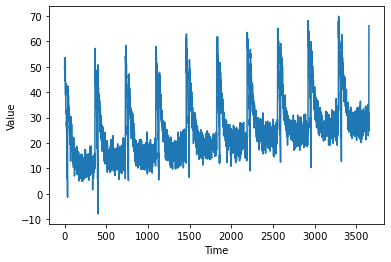

Your output:


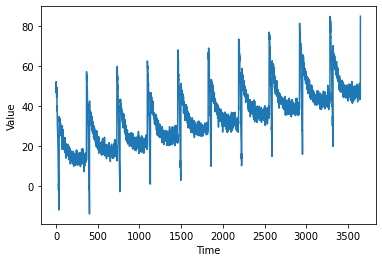

In [15]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# # # # # expected output
!gdown --id 1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
print("Expected:")
from IPython.display import display
from PIL import Image
path='./C4_W2_Assignment_Image.png'
display(Image.open(path))
# # # # #

### your output
print("Your output:")
plot_series(time, series)

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"), # The bracket [] is essential
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 268.3440
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 43.6029
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 36.8871
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 32.5716
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 30.2719
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 28.8976
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 27.6609
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 26.5210
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 25.8083
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 25.0882
Epoch 11/100
94/94 [==============================] - 1s 6ms/step - loss: 24.5255
Epoch 12/100
94/94 [==============================] - 1s 6ms/step - loss: 24.1254
Epoch 13/100
94/94 [====

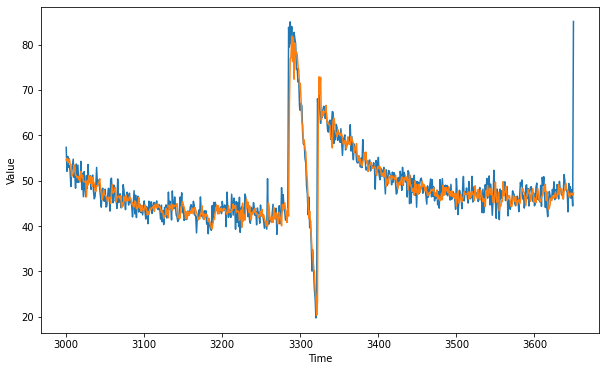

In [19]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.1048713